<a href="https://colab.research.google.com/github/krdlnsnks/Miuul/blob/main/CLT_PREDICTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 17.2 MB/s eta 0:00:00


In [3]:
import pandas as pd
import datetime as dt
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter
from lifetimes.plotting import plot_period_transactions

In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.4f' % x)
from sklearn.preprocessing import MinMaxScaler

In [5]:
from google.colab import files
uploaded = files.upload()

Saving online_retail_II.xlsx to online_retail_II.xlsx


In [6]:
import io
df = pd.read_excel(io.BytesIO(uploaded['online_retail_II.xlsx']))

In [7]:
df.isnull().sum()

Invoice             0
StockCode           0
Description      2928
Quantity            0
InvoiceDate         0
Price               0
Customer ID    107927
Country             0
dtype: int64

In [8]:
df.dropna(inplace=True)

In [9]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,417534.0000,12.7588,101.2204,-9360.0000,2.0000,4.0000,12.0000,19152.0000
Price,417534.0000,3.8875,71.1318,0.0000,1.2500,1.9500,3.7500,25111.0900
Customer ID,417534.0000,15360.6455,1680.8113,12346.0000,13983.0000,15311.0000,16799.0000,18287.0000


In [10]:
df = df[~df["Invoice"].str.contains("C", na=False)]

In [11]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407695.0000,13.5867,96.8422,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407695.0000,3.2942,34.7567,0.0000,1.2500,1.9500,3.7500,10953.5000
Customer ID,407695.0000,15368.5041,1679.7957,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [12]:
df = df[(df['Quantity'] > 0)]

In [13]:
df = df[(df['Price'] > 0)]

In [14]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Quantity,407664.0000,13.5856,96.8407,1.0000,2.0000,5.0000,12.0000,19152.0000
Price,407664.0000,3.2944,34.7580,0.0010,1.2500,1.9500,3.7500,10953.5000
Customer ID,407664.0000,15368.5926,1679.7621,12346.0000,13997.0000,15321.0000,16812.0000,18287.0000


In [16]:
df["TotalPrice"] = df["Quantity"] * df["Price"]

In [17]:
today_date = dt.datetime(2011, 12 ,11)

In [18]:
cltv_df = df.groupby('Customer ID').agg({'InvoiceDate': [lambda date: (date.max() - date.min()).days,
                                                         lambda date: (today_date - date.min()).days],
                                         'Invoice' : lambda num: num.nunique(),
                                         'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

In [19]:
cltv_df.head()

InvoiceDate             Invoice TotalPrice
             <lambda_0> <lambda_1> <lambda>   <lambda>
Customer ID                                           
12346.0000          196        726       11   372.8600
12347.0000           37        405        2  1323.3200
12348.0000            0        439        1   222.1600
12349.0000          181        590        3  2671.1400
12351.0000            0        376        1   300.9300

In [20]:
cltv_df.columns = cltv_df.columns.droplevel(0)

In [21]:
cltv_df.columns = ['recency', 'T', 'frequency', 'monetary']

In [22]:
cltv_df.head()

,recency,T,frequency,monetary
Customer ID,,,,
12346.0000,196,726,11,372.8600
12347.0000,37,405,2,1323.3200
12348.0000,0,439,1,222.1600
12349.0000,181,590,3,2671.1400
12351.0000,0,376,1,300.9300


In [23]:
cltv_df["monetary"] = cltv_df["monetary"] / cltv_df["frequency"]

In [24]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,4312.0000,133.9986,132.8272,0.0000,0.0000,105.0000,254.0000,373.0000
T,4312.0000,590.4970,118.9098,366.0000,482.0000,618.0000,694.0000,739.0000
frequency,4312.0000,4.4557,8.1702,1.0000,1.0000,2.0000,5.0000,205.0000
monetary,4312.0000,378.3226,492.5641,2.9500,182.0879,287.3681,423.5767,11880.8400


In [25]:
cltv_df = cltv_df[(cltv_df['frequency'] > 1)]

In [26]:
cltv_df["recency"] = cltv_df["recency"] / 7

In [27]:
cltv_df["T"] = cltv_df["T"] / 7

In [28]:
cltv_df.describe().T

,count,mean,std,min,25%,50%,75%,max
recency,2893.0000,28.5320,16.3933,0.0000,14.7143,29.8571,43.0000,53.2857
T,2893.0000,89.5359,14.7589,53.1429,80.1429,93.2857,103.5714,105.5714
frequency,2893.0000,6.1507,9.5274,2.0000,2.0000,4.0000,7.0000,205.0000
monetary,2893.0000,391.3880,421.9665,10.8222,201.8700,302.6890,441.1111,7488.9000


In [29]:
bgf = BetaGeoFitter(penalizer_coef=0.001)
bgf.fit(cltv_df['frequency'],
        cltv_df['recency'],
        cltv_df['T'])

<lifetimes.BetaGeoFitter: fitted with 2893 subjects, a: 1.93, alpha: 9.47, b: 6.27, r: 2.22>

In [ ]:
#1 hafta içinde en çok satın alma beklediğimiz 10 müşteri?

In [30]:
bgf.conditional_expected_number_of_purchases_up_to_time(1,
                                                        cltv_df['frequency'],
                                                        cltv_df['recency'],
                                                        cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0076
16720.0000   0.0072
14119.0000   0.0072
16204.0000   0.0072
17591.0000   0.0071
15169.0000   0.0070
17193.0000   0.0070
17251.0000   0.0070
17411.0000   0.0069
17530.0000   0.0068
dtype: float64

In [31]:
cltv_df["expected_purc_1_week"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [32]:
cltv_df

,recency,T,frequency,monetary,expected_purc_1_week
Customer ID,,,,,
12346.0000,28.0000,103.7143,11,33.8964,0.0000
12347.0000,5.2857,57.8571,2,661.6600,0.0004
12349.0000,25.8571,84.2857,3,890.3800,0.0014
12352.0000,2.2857,56.1429,2,171.9000,0.0002
12356.0000,6.2857,60.7143,3,1187.4167,0.0001
...,...,...,...,...,...
18276.0000,48.0000,104.2857,5,264.1320,0.0023
18277.0000,13.8571,70.7143,4,267.4175,0.0002
18283.0000,39.2857,94.1429,6,106.9617,0.0009


In [ ]:
# 1 ay içinde en çok satın alma beklenilen 10 müşteri kimdir?

In [34]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sort_values(ascending=False).head(10)

Customer ID
15989.0000   0.0299
16720.0000   0.0285
14119.0000   0.0284
16204.0000   0.0282
17591.0000   0.0282
15169.0000   0.0276
17193.0000   0.0276
17251.0000   0.0275
17411.0000   0.0273
17530.0000   0.0268
dtype: float64

In [35]:
cltv_df["expected_purc_1_month"] = bgf.predict(1,
                                              cltv_df['frequency'],
                                              cltv_df['recency'],
                                              cltv_df['T'])

In [36]:
bgf.predict(4,
            cltv_df['frequency'],
            cltv_df['recency'],
            cltv_df['T']).sum()

11.608238398752206

In [ ]:
#Tahmin sonuçlarının değerlendirilmesi

<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

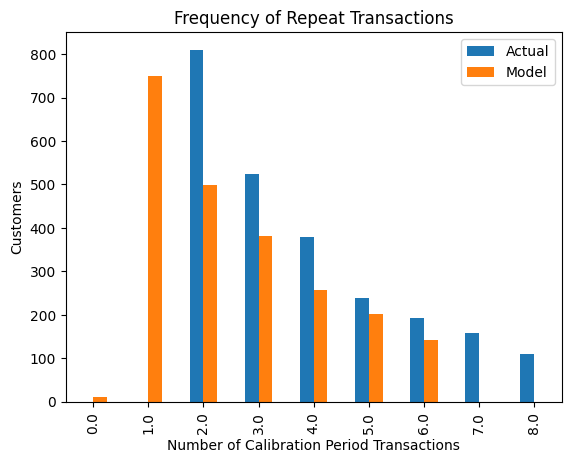

In [38]:
plot_period_transactions(bgf)

In [39]:
ggf = GammaGammaFitter(penalizer_coef=0.01)

In [40]:
ggf.fit(cltv_df['frequency'], cltv_df['monetary'])

<lifetimes.GammaGammaFitter: fitted with 2893 subjects, p: 3.79, q: 0.34, v: 3.72>

In [41]:
ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                        cltv_df['monetary']).head(10)

Customer ID
12346.0000     34.7880
12347.0000    727.1387
12349.0000    946.8475
12352.0000    190.4207
12356.0000   1262.2826
12357.0000   6621.1461
12358.0000    963.7925
12359.0000    440.6993
12360.0000    330.4757
12361.0000    115.0687
dtype: float64

In [42]:
cltv_df["expected_average_value"] = ggf.conditional_expected_average_profit(cltv_df['frequency'],
                                                                            cltv_df['monetary'])

In [43]:
 cltv = ggf.customer_lifetime_value(bgf,
                                       cltv_df['frequency'],
                                       cltv_df['recency'],
                                       cltv_df['T'],
                                       cltv_df['monetary'],
                                       time=3,  # 3 aylık
                                       freq="W", # T'nin frekans bilgisi
                                       discount_rate=0.01)

In [45]:
cltv.head()

Customer ID
12346.0000    0.0002
12347.0000    3.2768
12349.0000   16.0010
12352.0000    0.3765
12356.0000    1.9088
Name: clv, dtype: float64

In [46]:
cltv = cltv.reset_index()

In [47]:
cltv.head()

,Customer ID,clv
0,12346.0000,0.0002
1,12347.0000,3.2768
2,12349.0000,16.0010
3,12352.0000,0.3765
4,12356.0000,1.9088


In [48]:
cltv_final = cltv_df.merge(cltv, on="Customer ID", how="left")

In [50]:
cltv_final.sort_values(by="clv", ascending=False).head(10)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_value,cltv,clv
67,12497.0000,34.8571,92.1429,2,2602.7000,0.0042,0.0042,2854.2847,145.1298,145.1298
1671,15823.0000,51.1429,104.5714,3,1294.0567,0.0062,0.0062,1375.5279,103.3754,103.3754
83,12557.0000,50.1429,103.2857,4,1681.2950,0.0046,0.0046,1759.1816,97.0242,97.0242
1059,14564.0000,42.8571,105.1429,2,1302.8100,0.0044,0.0044,1429.7619,76.9780,76.9780
2708,17857.0000,39.2857,91.7143,2,901.6000,0.0061,0.0061,990.0840,73.0407,73.0407
2127,16732.0000,46.8571,104.5714,3,1261.2967,0.0044,0.0044,1340.7388,71.8146,71.8146
6,12358.0000,50.8571,104.5714,3,906.3367,0.0061,0.0061,963.7925,70.9021,70.9021
449,13373.0000,45.2857,104.8571,3,1424.9800,0.0038,0.0038,1514.5607,69.9180,69.9180
58,12477.0000,31.8571,89.1429,3,2352.2100,0.0023,0.0023,2499.2234,68.9116,68.9116
42,12435.0000,48.5714,105.4286,4,1524.0100,0.0035,0.0035,1594.7013,66.4544,66.4544


In [51]:
cltv_final["segment"] = pd.qcut(cltv_final["clv"], 4, labels=["D", "C", "B", "A"])

In [53]:
cltv_final.sort_values(by="clv", ascending=False).head(50)

,Customer ID,recency,T,frequency,monetary,expected_purc_1_week,expected_purc_1_month,expected_average_value,cltv,clv,segment
67,12497.0000,34.8571,92.1429,2,2602.7000,0.0042,0.0042,2854.2847,145.1298,145.1298,A
1671,15823.0000,51.1429,104.5714,3,1294.0567,0.0062,0.0062,1375.5279,103.3754,103.3754,A
83,12557.0000,50.1429,103.2857,4,1681.2950,0.0046,0.0046,1759.1816,97.0242,97.0242,A
1059,14564.0000,42.8571,105.1429,2,1302.8100,0.0044,0.0044,1429.7619,76.9780,76.9780,A
2708,17857.0000,39.2857,91.7143,2,901.6000,0.0061,0.0061,990.0840,73.0407,73.0407,A
2127,16732.0000,46.8571,104.5714,3,1261.2967,0.0044,0.0044,1340.7388,71.8146,71.8146,A
6,12358.0000,50.8571,104.5714,3,906.3367,0.0061,0.0061,963.7925,70.9021,70.9021,A
449,13373.0000,45.2857,104.8571,3,1424.9800,0.0038,0.0038,1514.5607,69.9180,69.9180,A
58,12477.0000,31.8571,89.1429,3,2352.2100,0.0023,0.0023,2499.2234,68.9116,68.9116,A
42,12435.0000,48.5714,105.4286,4,1524.0100,0.0035,0.0035,1594.7013,66.4544,66.4544,A
